# Generative Adversarial Networks

Применение adversarial loss (более общей идеи, лежащей в основе GANов) позволило решить задачи, которые казались невозможными:

* [Машинный перевод без параллельных данных](https://arxiv.org/pdf/1710.11041.pdf)
* [Циклоганы: перевод изображений в другой домен](https://arxiv.org/abs/1703.10593)
* Колоризация и [Super Resolution](https://arxiv.org/abs/1807.02758)
* [Генерация и морфинг произвольных данных](https://arxiv.org/pdf/1809.11096.pdf) ([тут](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=HuCO9tv3IKT2) можно поиграться с генерацией бургеров)
* Применения в борьбе с adversarial атаками

Вот постоянно пополняющийся список приложений GANов: https://github.com/nashory/gans-awesome-applications

Сама [статья](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) Яна Гудфеллоу про GANы вышла в конце 2014 года и была процитирована 7687 раз за 4 года.


<img width='500px' src='https://cdn-images-1.medium.com/max/800/1*eWURQXT41pwHvDg1xDiEmw.png'>

Теперь немного формальных определений:

* Пусть $z$ — это вектор из латентного пространства, насэмпленный из нормального распределения.
* $G(z)$ обозначает функцию генератора, которая отображает латентный вектор в пространство данных. Цель $G$ — оценить истинное распределение данных $p_d$, чтобы сэмплировать данные из оцененного распределения $p_g$.
* $D(G(z))$ это вероятность (число от 0 до 1), что выход генератора $G$ является реальным изображением.

$D$ и $G$ играют в минимаксную игру, в которой $D$ старается максимизировать вероятность, что он правильно классифицирует реальные и сгенерированные сэмплы, а $G$ старается минимизировать эту вероятность:

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]$$

[Выясняется](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), что решение в этой минимаксной игре достигается при $p_g = p_d$ (и дискриминатор в этом случае может угадывать случайно). В реальности модели не всегда могут сойтись к этой точке.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional GAN) называют GAN, который явно использует свёртки и транспонированные свёртки в дискриминаторе и генераторе соответственно. Откройте статью -- мы будем идти очень близко с авторами.

## Датасет
Всем надоели цифры, поэтому обучаться мы будем на датасете CelebA ([Large-scale CelebFaces Attributes](Large-scale CelebFaces Attributes)). В датасете на каждую фотку есть её аттрибуты, но мы их пока использовать не будем.

<img width='500px' src='http://mmlab.ie.cuhk.edu.hk/projects/celeba/overview.png'>

Автор, когда готовил эту тетрадку, долго думал, как загрузить датасет, чтобы всем было удобно. Это оказалось трудно, потому что прямых ссылок на него нигде нет, и, соответственно, просто сделать `!wget ...` нельзя. По удачному стечению обстоятельств, неделю назад кто-то [добавил](https://github.com/pytorch/vision/blob/master/torchvision/datasets/celeba.py) скрипты для загрузки этого датасета в сам `torchvision`, но в `pip` новая версия за такой срок ещё не успела появиться, поэтому мы обновимся напрямую из репозитория на гитхабе:

In [1]:
!nvidia-smi

Tue Mar 23 07:55:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# модель будет обучаться долго - рекомендую сохранять промежуточные версии. В колабе это можно делать примерно так
from google.colab import drive
drive.mount('/content/drive')
#теперь для сохранения файлов вам доступна директория /content/drive

Mounted at /content/drive


In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
id = "18UTENzuzvwViI0c9uELD4eN4Z9W0H83b"
gdd.download_file_from_google_drive(file_id=id, dest_path='./img_align_celeba.zip',
                                    unzip=True)

Unzipping...Done.


In [4]:
!mkdir "tmp"
!cp -R "/content/img_align_celeba" "/content/tmp/"

In [5]:
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms, datasets
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
from matplotlib import pyplot as plt

manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


In [6]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 128

In [7]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])

dataset = datasets.ImageFolder(root='/content/tmp/', transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

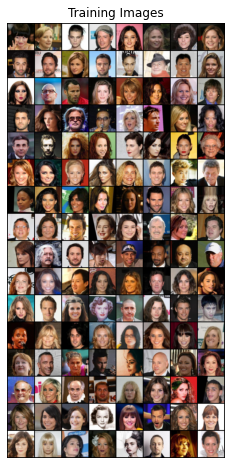

In [8]:
real_batch = next(iter(loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

## Модель

Генератор $G$ преобразует латентный вектор $z$ в пространство данных (в нашем случае -- картинки 3x64x64). В статье используют последовательность блоков из транспонированных свёрток, BatchNorm-ов и ReLU. На выходе каждое значение лежит в [-1, 1] (мы делаем TanH), в соответствии с нормализацией, которую мы сделали раньше.

<img width='600px' src='https://pytorch.org/tutorials/_images/dcgan_generator.png'>

In [9]:
num_channels = 3
latent_size = 100
base_size = 64

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(latent_size, base_size * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.SELU(True),
    
    # (base_size*8) x 4 x 4
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.SELU(True),
    
    # (base_size*4) x 8 x 8
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.SELU(True),
    
    # (base_size*2) x 16 x 16
    nn.ConvTranspose2d(base_size * 2, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.SELU(True),
    
    # (base_size) x 32 x 32
    nn.ConvTranspose2d(base_size, num_channels, 4, 2, 1, bias=False),
    nn.Tanh()
    # (num_channels) x 64 x 64
).to(device)

In [10]:
z = torch.randn(1, latent_size, 1, 1).to(device)
G(z)

tensor([[[[ 0.0687,  0.8244,  0.4776,  ..., -0.5172,  0.1856,  0.3158],
          [-0.7369,  0.1146,  0.2422,  ...,  0.1252, -0.6050, -0.2563],
          [ 0.4933,  0.9545, -0.4822,  ...,  0.7995,  0.0502, -0.1379],
          ...,
          [ 0.1890, -0.3924, -0.4296,  ..., -0.0587,  0.7758,  0.2719],
          [ 0.2317, -0.6079,  0.8194,  ..., -0.4471, -0.9195,  0.2437],
          [ 0.1060,  0.5749,  0.1926,  ..., -0.1080,  0.1437,  0.0865]],

         [[-0.2608, -0.4755, -0.4358,  ..., -0.4670, -0.4920, -0.0768],
          [-0.5970, -0.4695, -0.0020,  ...,  0.1242, -0.9353, -0.0084],
          [ 0.5842, -0.4901, -0.0541,  ..., -0.3201, -0.4361,  0.1906],
          ...,
          [ 0.4752, -0.5716,  0.1895,  ...,  0.1151, -0.5984, -0.1001],
          [ 0.1621,  0.1438, -0.6315,  ...,  0.4946, -0.8186, -0.3678],
          [-0.2809, -0.2641, -0.1917,  ...,  0.4481, -0.1651, -0.1193]],

         [[-0.2710,  0.2532, -0.3312,  ...,  0.1570, -0.1936,  0.0387],
          [-0.5838,  0.1572, -

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d... Параметры сверток можно поставить в обратную сторону.

In [11]:
D = nn.Sequential(
    #Input = 64x64
    nn.Conv2d(num_channels, base_size, 4, 2, 1, bias=False),
    nn.GELU(),
    #base_size * 32x32
    nn.Conv2d(base_size, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.GELU(),
    nn.Dropout(0.3),
    #base_size*2 x 16x16
    nn.Conv2d(base_size * 2, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.GELU(),
    nn.Dropout(0.3),
    #base_size*4 x 8x8
    nn.Conv2d(base_size * 4, base_size * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.GELU(),
    nn.Dropout(0.3),
    #base_size*8 x 4x4
    nn.Conv2d(base_size * 8, 1, 4, 2, 0, bias=False),
    nn.Sigmoid()
).to(device)

In [12]:
z = torch.randn(1, num_channels, image_size, image_size).to(device)
D(z)

tensor([[[[0.7345]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет применяет функцию ко всем своим подмодулям


In [14]:
G.apply(weights_init)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): SELU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): SELU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): SELU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [15]:
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GELU()
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): GELU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): GELU()
  (9): Dropout(p=0.3, inplace=False)
  (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): GELU()
  (13): Dropout(p=0.3, inplace=False)
  (14): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (15): Sigmoid()
)

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

In [ ]:
# если мы предварительно сохраняли модели и хотим запустить их, то это вот так
D.load_state_dict(torch.load('/content/drive/My Drive/D_gan.pt')) # можно и другую директорию, но вот это прямо внутри вашего гугл диска
G.load_state_dict(torch.load('/content/drive/My Drive/G_gan.pt'))

<All keys matched successfully>

In [17]:
num_epochs = 10
lr = 2e-3

img_list = []
G_losses = []
D_losses = []
iters = 0

criterion = nn.BCELoss()

fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
real_label, fake_label = 1, 0

optim_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    print('_'*20 + f'EPOCH_{epoch}' + '_'*20)
    for (data, _) in loader:
        # Обучать GANы всегда долго, и мы хотим по максимуму переиспользовать вычисления

        # 1. Обучим D: max log(D(x)) + log(1 - D(G(z)))
        D.zero_grad()

        real_images = data.to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = D(real_images).view(-1)
        D_loss_real = criterion(output, label)
        D_loss_real.backward()

        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        D_loss_fake = criterion(output, label)
        D_loss_fake.backward() 

        D_loss = D_loss_real + D_loss_fake
        optim_D.step()

        # 2. Обучим G: max log(D(G(z)))

        G.zero_grad()
        label.fill_(real_label) 
        output = D(fake).view(-1)
        G_loss = criterion(output, label)
        G_loss.backward()
        optim_G.step()

        # Раз в сколько-то итераций логгируем лосс
        if iters % 100 == 0:
            # Выведем информацию о том, как наша сеть справляется
            print(f'{epoch}/{num_epochs}, {(iters-epoch*len(loader))/len(loader)*100}%')
            print(f'  G loss: {G_loss}')
            print(f'  D loss: {D_loss}')
            print()
            
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if iters % 700 == 0:
            # вы на этом батче уже генерировали какие-то картинки: просто добавьте их в список
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            # а вот тут сохраняем
            torch.save(D.state_dict(), '/content/drive/My Drive/D_gan.pt')
            torch.save(G.state_dict(), '/content/drive/My Drive/G_gan.pt')
            print('Weights saved')
        iters += 1
    print(": Saving current results...")
    vutils.save_image(fake.data, '%s/fake_samples_%03d.png' %('/content', epoch),
    normalize=True
    )

____________________EPOCH_0____________________
0/10, 0.0%
  G loss: 0.5037246346473694
  D loss: 1.7913826704025269

Weights saved
0/10, 6.3171193935565375%
  G loss: 1.683821439743042
  D loss: 1.4828773736953735

0/10, 12.634238787113075%
  G loss: 0.7897103428840637
  D loss: 3.5410304069519043

0/10, 18.951358180669615%
  G loss: 4.099802494049072
  D loss: 3.011734962463379

0/10, 25.26847757422615%
  G loss: 3.6083946228027344
  D loss: 1.043653964996338

0/10, 31.585596967782692%
  G loss: 3.0145764350891113
  D loss: 0.6030069589614868

0/10, 37.90271636133923%
  G loss: 2.888477325439453
  D loss: 4.26493501663208

0/10, 44.21983575489577%
  G loss: 3.0138707160949707
  D loss: 0.289506733417511

Weights saved
0/10, 50.5369551484523%
  G loss: 2.884812355041504
  D loss: 0.6305798888206482

0/10, 56.854074542008846%
  G loss: 6.704962730407715
  D loss: 0.6136051416397095

0/10, 63.171193935565384%
  G loss: 4.281733989715576
  D loss: 0.30791980028152466

0/10, 69.4883133291

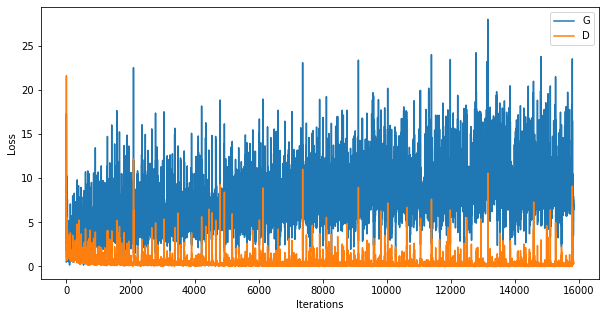

In [18]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

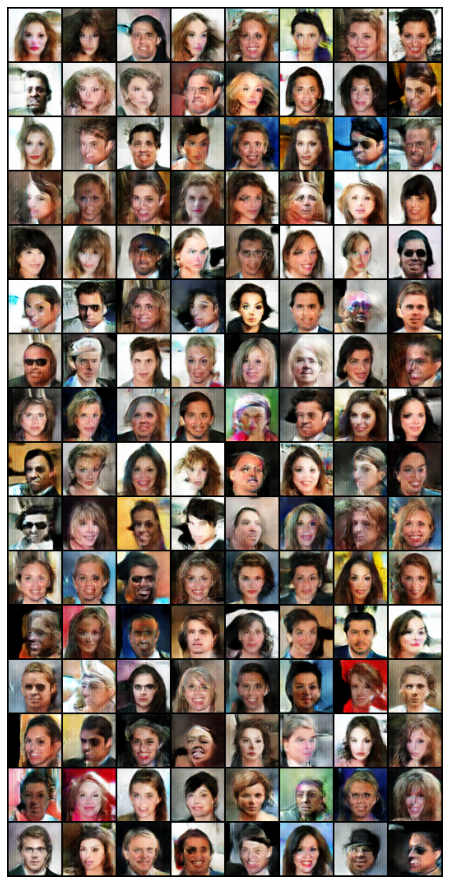

In [19]:
fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()

In [20]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.